# **News Topic Classifier Using BERT**

* 🔹 Fine-tunes bert-base-uncased using PyTorch (not Hugging Face Trainer).
* 🔹 Loads and processes the AG News dataset from public GitHub CSV files.
* 🔹 Merges title and description into a single text field for classification.
* 🔹 Selects a 5,000-sample subset to reduce training time and resource use.
* 🔹 Applies BERT tokenization with padding=True, truncation=True, and max_length.
* 🔹 Converts tokenized data and labels into PyTorch tensors via a custom Dataset class.
* 🔹 Implements a manual training loop with GPU support using AdamW and CrossEntropyLoss.
* 🔹 Trains the model for 1 epoch with live progress tracking using tqdm.
* 🔹 Evaluates the model on the test set using accuracy and F1-score.
* 🔹 Prepares the trained model for deployment via a Gradio web app interface.

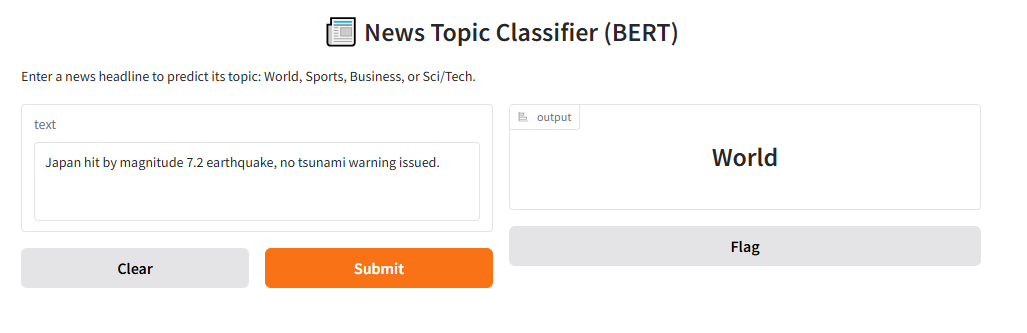

## ✅ Full Manual BERT Training Code (PyTorch, AG News, 5k subset, 1 epoch)


---



---



### Install and Import Required Libraries:

In [1]:
!pip install transformers datasets -q

In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm

### Load and Preprocess AG News Dataset:

In [3]:
# URLs
train_url = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv"
test_url  = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv"

# Load CSVs
train_df = pd.read_csv(train_url, header=None)
test_df  = pd.read_csv(test_url,  header=None)

# Add column names
train_df.columns = ["label", "title", "description"]
test_df.columns  = ["label", "title", "description"]

# Combine title and description
train_df["text"] = train_df["title"] + " " + train_df["description"]
test_df["text"]  = test_df["title"]  + " " + test_df["description"]

# Fix labels from 1–4 → 0–3
train_df["label"] = train_df["label"] - 1
test_df["label"]  = test_df["label"] - 1

# Use 5000 training & 1000 testing samples
train_df = train_df[:5000]
test_df = test_df[:1000]

### Tokenize with BERT:

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def encode_texts(texts, labels):
    tokens = tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    tokens["labels"] = torch.tensor(labels)
    return tokens

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Create PyTorch Dataset:

In [5]:
class AGNewsDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

In [6]:
# Encode both sets
train_encodings = encode_texts(train_df["text"], train_df["label"])
test_encodings = encode_texts(test_df["text"], test_df["label"])

# Build Dataset objects
train_dataset = AGNewsDataset(train_encodings)
test_dataset = AGNewsDataset(test_encodings)

### Load BERT Model:

In [7]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Train the Model:

In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
optimizer = AdamW(model.parameters(), lr=2e-5)

model.train()
for epoch in range(1):
    total_loss = 0
    loop = tqdm(train_loader, desc="Training")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loop.set_postfix(loss=loss.item())

print(f"\n✅ Training complete! Total loss: {total_loss:.2f}")

Training: 100%|██████████| 313/313 [1:37:57<00:00, 18.78s/it, loss=0.397]


✅ Training complete! Total loss: 156.56


### Evaluate the Model:

In [9]:
from sklearn.metrics import accuracy_score, classification_report

test_loader = DataLoader(test_dataset, batch_size=16)
model.eval()
predictions, labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        labels.extend(batch["labels"].cpu().numpy())

acc = accuracy_score(labels, predictions)
print(f"\n🎯 Test Accuracy: {acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(labels, predictions, digits=4))


🎯 Test Accuracy: 0.8880

Classification Report:

              precision    recall  f1-score   support

           0     0.8115    0.9478    0.8744       268
           1     0.9705    0.9599    0.9651       274
           2     0.9097    0.6878    0.7833       205
           3     0.8812    0.9091    0.8949       253

    accuracy                         0.8880      1000
   macro avg     0.8932    0.8761    0.8794      1000
weighted avg     0.8928    0.8880    0.8858      1000



## 🚀 News Topic Classifier – Gradio Web App (Deployed BERT Model for Inference)


---



---



### News Label Mapping (AG News)

In [10]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]

### Install Gradio:

In [11]:
!pip install gradio -q

### Define Prediction Function:

In [12]:
import torch
import gradio as gr

# Make sure model is in eval mode
model.eval()

def classify_news(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=1).item()

    return label_names[predicted_class_id]

### Create Gradio Interface:

In [13]:
interface = gr.Interface(
    fn=classify_news,
    inputs=gr.Textbox(lines=3, placeholder="Enter a news headline..."),
    outputs=gr.Label(num_top_classes=1),
    title="📰 News Topic Classifier (BERT)",
    description="Enter a news headline to predict its topic: World, Sports, Business, or Sci/Tech."
)

# Launch app
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fa43532efb445598ab.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
